#### Importing libraries

In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns
from scipy import stats


#### Uploading and preparing data

In [2]:
df = pd.read_csv('/Users/igorrudakov/Desktop/CRM_Senior Data Analyst/cs_data.csv')
df = df.rename(columns={'Unnamed: 0':'local_id'})
df.head()

,local_id,analytical_customer_id,voucher_group,segment_frequency_rest,segment_monetary_rest,segment_discount_dh_rest,segment_variety_rest,segment_basket_rest,lt_order_cluster,recency_cluster,lt_cluster,times_in_churn_segments,preferred_order_period_all_verts,loyalty_status_all_verts,returning_probability_segments,orders,margin
0,5,00004b56-d951-4693-aa69-d1986cac9ae0,lv-2|3|18,B,M,N,H,2,5+,90-120,720+,4+,multi weekday | multi daytime,Inactive Loyal,0.7-1,0,0.00
1,11,00008a4a-0e9a-4c05-8cef-01feaf7d5254,hv-2|10|25,E,L,N,N,1,5+,120-180,360-720,4+,single weekday | single daytime,Inactive Loyal,0.5-0.7,2,7.91
2,24,000147e2-b93d-4ca8-bd05-25014e0f7874,Control Group,E,M,H,N,1,5+,120-180,720+,4+,single weekday | single daytime,Inactive Loyal,0.5-0.7,11,1.06
3,29,000172b4-f65e-43f2-b401-02f9c377c892,hv-1|10|13,B,L,N,H,2,5+,30-60,<180,2-3,multi weekday | multi daytime,Inactive Multiple Orders,0.7-1,1,5.88
4,32,0001b27c-9814-4ec4-8eb9-2465f82b0c82,lv-1|3|9,F,L,N,N,1,1,90-120,<180,1,single weekday | single daytime,Inactive Churning 1 Timer,0.3-0.5,0,0.00


In [3]:
df.dtypes

local_id                              int64
analytical_customer_id               object
voucher_group                        object
segment_frequency_rest               object
segment_monetary_rest                object
segment_discount_dh_rest             object
segment_variety_rest                 object
segment_basket_rest                   int64
lt_order_cluster                     object
recency_cluster                      object
lt_cluster                           object
times_in_churn_segments              object
preferred_order_period_all_verts     object
loyalty_status_all_verts             object
returning_probability_segments       object
orders                                int64
margin                              float64
dtype: object

In [4]:
# Introducing new columns

df['order_x_margin'] = df.orders * df.margin
df['segment_basket_rest'] = df.segment_basket_rest.apply(lambda x: str(x))
df['treatment_flg'] = df.voucher_group.apply(lambda x: 'control' if x == 'Control Group' else 'treatment')

In [5]:
df.describe()


,local_id,orders,margin,order_x_margin
count,2.374880e+05,237488.000000,237488.000000,237488.000000
mean,6.167213e+05,0.771125,2.747782,13.747128
std,3.607970e+05,1.819938,8.539605,147.946964
min,5.000000e+00,0.000000,-385.600000,-2039.940000
25%,3.029680e+05,0.000000,0.000000,0.000000
50%,6.126340e+05,0.000000,0.000000,0.000000
75%,9.280935e+05,1.000000,2.380000,2.500000
max,1.249696e+06,100.000000,387.120000,36329.000000


<AxesSubplot:xlabel='margin', ylabel='Count'>

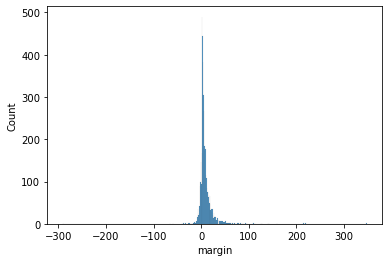

In [15]:
(sns.histplot(df[(df.voucher_group == 'hv-2|10|25')&(df.margin != 0)]['margin']))

In [22]:
stats.shapiro(df[(df.voucher_group == 'hv-2|10|25')&(df.margin != 0)]['margin'])

ShapiroResult(statistic=0.5618950128555298, pvalue=0.0)

the distribution of samples is not normal, but thanks to CLT we can still apply Welch t test to compare means.
Since (1) we have lots of observations for each voucher, (2) if we take multiply samples from the initial population and calculate
means for each sample - the distribution of means will follow the normal distribution under the CLT

In [26]:
df.groupby('voucher_group', as_index=False)\
    .agg({'local_id':'nunique'})

,voucher_group,local_id
0,Control Group,115577
1,hv-1|10|13,13477
2,hv-2|10|25,13266
3,hv-3|10|38,13671
4,lv-1|3|9,13471
5,lv-2|3|18,13695
6,lv-3|3|27,13666
7,mv-1|6|10,13571
8,mv-2|6|20,13520
9,mv-3|6|30,13574


#### Answering the questions

##### What is the best voucher overall? 

In [27]:
cg_g_rows = df[(df.voucher_group =='Control Group')]
tg_g_rows = df[(df.voucher_group !='Control Group')]

For each voucher we need to get two main columns: uplift vs global control group, p-value from mannwhitneyu test. 
After that we choose voucher with greater uplift and p-value below 0.05

In [89]:
voucher_groups = []
mannwhitneyu_p = []
welch_ttest    = []

metrics        = []
uplifts        = []


# iterating through vouchers
for vg in tg_g_rows.voucher_group.unique():

    # iterating through metrics
    for metric in ['orders','margin','order_x_margin']:
        voucher_groups.append(vg)
        metrics.append(metric)
        
        # apply mannwhitneyu test
        mannwhitneyu_p.append(stats.mannwhitneyu(tg_g_rows[(tg_g_rows.voucher_group == vg)][f'{metric}'], 
                                                 cg_g_rows[f'{metric}'] 
                                                ).pvalue
                             )
 
        # apply welch test
        welch_ttest.append(stats.ttest_ind(tg_g_rows[(tg_g_rows.voucher_group == vg)][f'{metric}'], 
                                           cg_g_rows[f'{metric}'], equal_var=False 
                                          ).pvalue
                          )

        # store uplifts
        uplifts.append(tg_g_rows[(tg_g_rows.voucher_group == vg)][f'{metric}'].mean() / cg_g_rows[f'{metric}'].mean())
        
        
# get final dataframe
versus_global_cg = pd.DataFrame({'voucher_group' :voucher_groups,
                                 'metric':metrics,
                                 'uplift':uplifts,
                                 'mannwhitneyu_p_value': mannwhitneyu_p,
                                 'welch_p_value': welch_ttest,
               })


In [204]:
versus_global_cg[(versus_global_cg.metric == 'orders')].round(4).sort_values(by='uplift', ascending=False)

,voucher_group,metric,uplift,mannwhitneyu_p_value,welch_p_value
6,hv-1|10|13,orders,1.1717,0.0000,0.0000
3,hv-2|10|25,orders,1.1245,0.0000,0.0000
21,mv-1|6|10,orders,1.0978,0.0000,0.0000
12,lv-3|3|27,orders,1.0660,0.0035,0.0029
15,mv-2|6|20,orders,1.0571,0.0000,0.0125
9,lv-1|3|9,orders,1.0479,0.0000,0.0282
24,hv-3|10|38,orders,1.0420,0.0023,0.0553
18,mv-3|6|30,orders,1.0345,0.0131,0.1093
0,lv-2|3|18,orders,1.0164,0.0131,0.4416


In [206]:
versus_global_cg[(versus_global_cg.metric == 'margin')].round(4).sort_values(by='uplift', ascending=False)

,voucher_group,metric,uplift,mannwhitneyu_p_value,welch_p_value
13,lv-3|3|27,margin,1.0786,0.0235,0.0111
19,mv-3|6|30,margin,1.0462,0.0607,0.1016
1,lv-2|3|18,margin,1.0175,0.1317,0.5432
10,lv-1|3|9,margin,0.9996,0.0116,0.9861
4,hv-2|10|25,margin,0.9932,0.0001,0.8252
25,hv-3|10|38,margin,0.9904,0.4205,0.7324
16,mv-2|6|20,margin,0.9829,0.2626,0.5413
22,mv-1|6|10,margin,0.9395,0.0000,0.0186
7,hv-1|10|13,margin,0.8937,0.0000,0.0001


In [92]:
versus_global_cg[(versus_global_cg.metric == 'order_x_margin')].round(4).sort_values(by='mannwhitneyu_p_value', ascending=True)

,voucher_group,metric,uplift,mannwhitneyu_p_value,welch_p_value
8,hv-1|10|13,order_x_margin,1.0108,0.0000,0.8916
23,mv-1|6|10,order_x_margin,0.8857,0.0000,0.0905
5,hv-2|10|25,order_x_margin,1.0953,0.0004,0.3344
11,lv-1|3|9,order_x_margin,0.9300,0.0079,0.3292
14,lv-3|3|27,order_x_margin,1.0978,0.0172,0.2882
20,mv-3|6|30,order_x_margin,1.0063,0.0538,0.9352
2,lv-2|3|18,order_x_margin,0.9659,0.1244,0.6765
17,mv-2|6|20,order_x_margin,0.9955,0.1678,0.9596
26,hv-3|10|38,order_x_margin,0.9992,0.4815,0.9937


Best overall  : lv-3|3|27  - maximizes orders and margin (+7.8% margin, +6.6% orders)

Best by orders: hv-1|10|13 - maximizes orders but drops margin considerably (+17% orders, -10.6% margin)

##### What is the best single dimensions segmentation to be used? 

In [82]:
df.head()

,local_id,analytical_customer_id,voucher_group,segment_frequency_rest,segment_monetary_rest,segment_discount_dh_rest,segment_variety_rest,segment_basket_rest,lt_order_cluster,recency_cluster,lt_cluster,times_in_churn_segments,preferred_order_period_all_verts,loyalty_status_all_verts,returning_probability_segments,orders,margin,order_x_margin,treatment_flg
0,5,00004b56-d951-4693-aa69-d1986cac9ae0,lv-2|3|18,B,M,N,H,2,5+,90-120,720+,4+,multi weekday | multi daytime,Inactive Loyal,0.7-1,0,0.00,0.00,treatment
1,11,00008a4a-0e9a-4c05-8cef-01feaf7d5254,hv-2|10|25,E,L,N,N,1,5+,120-180,360-720,4+,single weekday | single daytime,Inactive Loyal,0.5-0.7,2,7.91,15.82,treatment
2,24,000147e2-b93d-4ca8-bd05-25014e0f7874,Control Group,E,M,H,N,1,5+,120-180,720+,4+,single weekday | single daytime,Inactive Loyal,0.5-0.7,11,1.06,11.66,control
3,29,000172b4-f65e-43f2-b401-02f9c377c892,hv-1|10|13,B,L,N,H,2,5+,30-60,<180,2-3,multi weekday | multi daytime,Inactive Multiple Orders,0.7-1,1,5.88,5.88,treatment
4,32,0001b27c-9814-4ec4-8eb9-2465f82b0c82,lv-1|3|9,F,L,N,N,1,1,90-120,<180,1,single weekday | single daytime,Inactive Churning 1 Timer,0.3-0.5,0,0.00,0.00,treatment


##### Assumptions

The main goal of segmentation is to improve customer promo (voucher) personalisation.

A good segmentation approach will lead to increased voucher redemption rate - which means grerater and more statistically significant uplift.
So, we need to identify segmentation approaches that have lowest p_values when evaluated against control group with the same segment.



##### Statistically significant lifts
The fast way to check this would by to run a Chi-Square test to check whether there is a difference in order distribution between treatment and control groups inside each segmentation method 
If segmentation doesn’t work we will see no significant differences - since we assume that bad segmentation leads to poor personalisation and low lifts

In [94]:
# all segmentation columns
segmentation_approaches = [
                             'segment_frequency_rest'
                            ,'segment_monetary_rest'
                            ,'segment_discount_dh_rest'
                            ,'segment_variety_rest'
                            ,'segment_basket_rest'
                            ,'lt_order_cluster'
                            ,'recency_cluster'
                            ,'lt_cluster'
                            ,'times_in_churn_segments'
                            ,'preferred_order_period_all_verts'
                            ,'loyalty_status_all_verts'
                            ,'returning_probability_segments']

In [95]:
# Get distributions of orders by control and treatment
# run a Chi-squared test

segmentation_nm = []
chi_squared_results = []

for segmentation_approach in segmentation_approaches:
    segmentation_nm.append(segmentation_approach)
    a = df.groupby([segmentation_approach,'treatment_flg'], as_index=False)\
            .agg(\
                orders_sum=('orders', np.sum)\
                )\
            .pivot(index=segmentation_approach, columns='treatment_flg', values='orders_sum').reset_index()
    chi_squared_results.append(stats.chisquare(a.control, a.treatment).pvalue)

chi_squared_for_segments = pd.DataFrame({'segmentation_approach':segmentation_nm,
                                         'chi_squared_p_value':chi_squared_results
                                       })
chi_squared_for_segments

,segmentation_approach,chi_squared_p_value
0,segment_frequency_rest,0.000000e+00
1,segment_monetary_rest,2.476678e-288
2,segment_discount_dh_rest,0.000000e+00
3,segment_variety_rest,3.216904e-301
4,segment_basket_rest,6.044300e-298
5,lt_order_cluster,0.000000e+00
6,recency_cluster,0.000000e+00
7,lt_cluster,1.742193e-296
8,times_in_churn_segments,0.000000e+00
9,preferred_order_period_all_verts,2.061196e-299


In [96]:
# will use bonferroni correction as quick estimate for p_value
chi_squared_for_segments[(chi_squared_for_segments.chi_squared_p_value > 0.05/12.0)]

,segmentation_approach,chi_squared_p_value


At least one segment in each segmentation approach statistically significantly differs from other buckets 

Then for segmentation methods that passed the test we need to sequentially check for the statistically significant difference between control and treatment groups for each bucket (inside segmentation method)


In [191]:
seg_group            = []
bucket_group         = []
uplifts_margin       = []
uplifts_orders       = []

mannwhitneyu_margin  = []

mannwhitneyu_orders  = []
vg_groups            = []

for segmentation_approach in segmentation_approaches:
    for bucket in cg_g_rows[f'{segmentation_approach}'].unique():
        for vg in tg_g_rows.voucher_group.unique():
            vg_groups.append(vg)
            seg_group.append(segmentation_approach)
            bucket_group.append(bucket)
            
#      uplift vs contol group            
            uplifts_margin.append(
                tg_g_rows[(tg_g_rows[f'{segmentation_approach}']==f'{bucket}') & (tg_g_rows.voucher_group == vg)].margin.mean()/\
                cg_g_rows[(cg_g_rows[f'{segmentation_approach}']==f'{bucket}')                                  ].margin.mean() )  # control

#      uplift vs contol group            
            uplifts_orders.append(
                tg_g_rows[(tg_g_rows[f'{segmentation_approach}']==f'{bucket}') & (tg_g_rows.voucher_group == vg)].orders.mean()/\
                cg_g_rows[(cg_g_rows[f'{segmentation_approach}']==f'{bucket}')                                  ].orders.mean() )  # control


# tests for margin            
            mannwhitneyu_margin.append(stats.mannwhitneyu(
                                tg_g_rows[(tg_g_rows[f'{segmentation_approach}']==f'{bucket}') & (tg_g_rows.voucher_group == vg)].margin,\
                                cg_g_rows[(cg_g_rows[f'{segmentation_approach}']==f'{bucket}')].margin
                            ).pvalue
                         )

# tests for orders            
            mannwhitneyu_orders.append(stats.mannwhitneyu(
                                tg_g_rows[(tg_g_rows[f'{segmentation_approach}']==f'{bucket}') & (tg_g_rows.voucher_group == vg)].orders,\
                                cg_g_rows[(cg_g_rows[f'{segmentation_approach}']==f'{bucket}')].orders
                            ).pvalue
                         )
       

seg_appr_dif = pd.DataFrame({'seg_group':seg_group,
                             'bucket_group':bucket_group,
                             'vg_groups':vg_groups,
                             'uplifts_margin':uplifts_margin,
                             'uplifts_orders':uplifts_orders,
                             'mannwhitneyu_margin':mannwhitneyu_margin,
                             'mannwhitneyu_orders':mannwhitneyu_orders,
               })

In [192]:
seg_appr_dif.head()

,seg_group,bucket_group,vg_groups,uplifts_margin,uplifts_orders,mannwhitneyu_margin,mannwhitneyu_orders
0,segment_frequency_rest,E,lv-2|3|18,1.024268,1.020949,0.063306,3.785461e-02
1,segment_frequency_rest,E,hv-2|10|25,1.097240,1.279805,0.413513,2.561670e-12
2,segment_frequency_rest,E,hv-1|10|13,1.009091,1.356736,0.000001,1.952906e-19
3,segment_frequency_rest,E,lv-1|3|9,1.052679,1.129136,0.004576,1.493447e-06
4,segment_frequency_rest,E,lv-3|3|27,1.126602,1.132745,0.010513,3.806863e-03


Different segments might react differently to different vouchers. That depends on vouchers' relevancy to that particular group. If voucher is relevant to a particular segment then the p value should be lower.
Also, there is such a thing as a very enticing voucher :) . For example, voucher  hv-1|10|13 gives the customer 10 USD if he/she spends from 13 USD. It is 75% discount and, understandably, customers will use it regardless of the segment. So, it is better to exclude such vouchers from the analysis.

<AxesSubplot:xlabel='margin', ylabel='Count'>

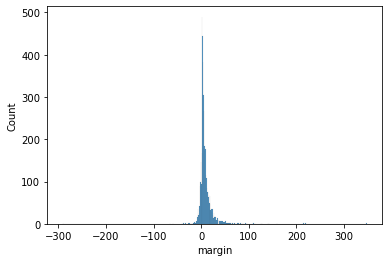

In [201]:
# sns.histplot( df[(df.voucher_group == 'hv-2|10|25') & (df.orders != 0)].orders)
# sns.histplot( df[(df.voucher_group == 'hv-2|10|25') & (df.margin != 0)].margin)

In [207]:
seg_appr_dif.to_excel('output_2.xlsx')

For each segmentation approach for each bucket we will get the uplift value if it is statistically significant (if not - the uplift would be 0) 
The best segmentation method will have more statistically significant uplifts (positive or negative) across buckets.
But it is easier to calculate those in excel


The best single dimensions segmentations are:
times_in_churn_segments

For each segment inside this approach we can find vouchers with lowest p_value
